In [4]:
# for running this it should be on the root of the project
%load_ext autoreload
%autoreload 2
import torch
import torch.optim as optim
import argparse
import pandas as pd
import os
from tqdm import tqdm
import sys
sys.path.insert(0, '/Users/maruanottoni/home/master/research/graph-corr-embedd/src')

from models.SAE import StackedSparseAutoencoder
from utils.conn_data import save_pickle
from utils.parsers import str_2_bool
from data.Simulation1Loader import Simulation1Loader
from simulation.GraphSim import GraphSim
from utils.activation_functions import sigmoid

from models.Spectrum import Spectrum

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy.stats import spearmanr, norm
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from scipy.stats import spearmanr
from tqdm import tqdm

import numpy as np
import networkx as nx
from scipy.stats import spearmanr
from tqdm import tqdm



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Defining params

In [9]:
simulation_name = "simulation2a"
source_path = f'/Users/maruanottoni/home/master/research/graph-corr-embedd/data/simulations/{simulation_name}'

In [10]:
sample=False

# Example usage
n_graphs = [10, 20]  # Example list of numbers of graphs 20,40,60,80,100
n_simulations = 25 # should be 1000
n_nodes = 40 # 50
covariance = 0 # testes with 0.5 and 0
graph_classes = [
    "erdos_renyi",
    "random_geometric",
    #"random_regular",
    #"barabasi_albert",
    #"watts_strogatz",
]


# Start simluation

In [18]:
def get_spearm_pvalues_baseline(params, n_graph, first_family, second_family, n_simulations):
    pvalues = []
    for _ in range(n_simulations):
        first_run = np.array(params[first_family][second_family][n_graph])[:,0]
        second_run = np.array(params[first_family][second_family][n_graph])[:,1]
        pvalues.append(spearmanr(first_run, second_run).pvalue)
    return pvalues

def get_spearman_pvalues(eigenvalues_dict, first_family_name, second_family_name, n_simulations, n_graph):
    pvalues = []
    for i in range(n_simulations):
        first_family = eigenvalues_dict[first_family_name][second_family_name][n_graph][i][0]
        second_family = eigenvalues_dict[first_family_name][second_family_name][n_graph][i][1]
        pvalues.append(spearmanr(first_family, second_family).pvalue)
    return pvalues

def simulation_graph_case(gs, theta, graph_name, n_nodes):
    if graph_name == "erdos_renyi":
        graph = gs.simulate_erdos(n=n_nodes, prob=theta)
    elif graph_name == "random_geometric":
        graph = gs.simulate_geometric(n=n_nodes, radius=theta)
    elif graph_name == "barabasi_albert":
        graph = gs.simulate_barabasi_albert(n=n_nodes, m=int(10*theta))
    elif graph_name == "watts_strogatz":
        graph = gs.simulate_watts_strogatz(n=n_nodes, k=3, p=theta)
    return graph

def get_dicts(n_graphs, graph_classes):
    embed_dict = {graph_name: {n_graph: [] for n_graph in n_graphs} for graph_name in graph_classes}
    embed_dict = {graph_name: embed_dict for graph_name in graph_classes}
    params_dict = {graph_name: {n_graph: [] for n_graph in n_graphs} for graph_name in graph_classes}
    params_dict = {graph_name: params_dict for graph_name in graph_classes}
    return embed_dict, params_dict

def simulate_vector_graphs(n_graph, graph_name1, graph_name2, n_nodes, covariance):
    embeddings1, embeddings2 = [], []
    thetas1, thetas2 = [], []

    gs = GraphSim(graph_name=graph_name1)  # It doesn't matter the graph_name here
    gs.update_seed()
    ps = gs.get_p_from_bivariate_gaussian(s=covariance, size=n_graph)
    ps = sigmoid(ps)  # normalize

    for j in range(n_graph):

        p1, p2 = ps[j, 0], ps[j, 1]

        # Generate parameters and normalize then gen graph
        graph1  = simulation_graph_case(gs, p1, graph_name1, n_nodes=n_nodes)
        graph2  = simulation_graph_case(gs, p2, graph_name2, n_nodes=n_nodes)
        ##############
        # Fujita method
        # TODO: Try embedders
        largest_eigenvalue1 = Spectrum().forward(nx.adjacency_matrix(graph1).A)
        largest_eigenvalue2 = Spectrum().forward(nx.adjacency_matrix(graph2).A)
        ############3##

        embeddings1.append(largest_eigenvalue1)
        embeddings2.append(largest_eigenvalue2)

        thetas1.append(p1)
        thetas2.append(p2)

    return embeddings1, embeddings2, thetas1, thetas2

def ensure_nested_dicts(embed_dict, params_dict, graph_name1, graph_name2, n_graph):
    if graph_name1 not in embed_dict:
        embed_dict[graph_name1] = {}
    if graph_name2 not in embed_dict[graph_name1]:
        embed_dict[graph_name1][graph_name2] = {}
    if n_graph not in embed_dict[graph_name1][graph_name2]:
        embed_dict[graph_name1][graph_name2][n_graph] = []
    
    if graph_name1 not in params_dict:
        params_dict[graph_name1] = {}
    if graph_name2 not in params_dict[graph_name1]:
        params_dict[graph_name1][graph_name2] = {}
    if n_graph not in params_dict[graph_name1][graph_name2]:
        params_dict[graph_name1][graph_name2][n_graph] = []
    
    return embed_dict, params_dict

def run_simulation(n_graphs, n_simulations, n_nodes, covariance, graph_classes):
    embed_dict, params_dict = get_dicts(n_graphs, graph_classes)
    simulated_combinations = set()

    for n_graph in n_graphs:
        for graph_name1 in tqdm(graph_classes, desc=f"Simulating {n_graph} graphs"):
            for graph_name2 in tqdm(graph_classes, desc=f"Simulating {n_graph} graphs"):
                
                # Check if this combination or its reverse has been simulated
                if (graph_name1, graph_name2, n_graph) in simulated_combinations or (graph_name2, graph_name1, n_graph) in simulated_combinations:
                    continue  # Skip this combination if it has already been simulated
                
                # Mark this combination as simulated
                simulated_combinations.add((graph_name1, graph_name2, n_graph))
                gs = GraphSim(graph_name=graph_name1)  # It doesn't matter the graph_name here

                for _ in range(n_simulations):
                    embeddings1, embeddings2, thetas1, thetas2 = simulate_vector_graphs(n_graph, graph_name1, graph_name2, n_nodes, covariance=covariance)

                    embed_dict, params_dict = ensure_nested_dicts(embed_dict=embed_dict, params_dict=params_dict,
                                                                  graph_name1=graph_name1, graph_name2=graph_name2,
                                                                  n_graph=n_graph)

                    # Store the results
                    embed_dict[graph_name1][graph_name2][n_graph].append((embeddings1, embeddings2))
                    params_dict[graph_name1][graph_name2][n_graph].append((thetas1, thetas2))

    return embed_dict, params_dict

def plot_roc_curves(graph_types, n_graphs, eigen, params, n_simulations):
    def calculate_rates(p_values, threshold):
        fp, tn = 0, 0
        for p_value in p_values:
            if p_value > threshold:
                fp += 1
            else:
                tn += 1
        return tn / (fp + tn) if (fp + tn) > 0 else 0

    fig, axs = plt.subplots(len(graph_types), len(graph_types), figsize=(15, 15))
    for n_graph in n_graphs:
        for i, gt1 in enumerate(graph_types):
            for j, gt2 in enumerate(graph_types):
                if j >= i:  # This condition ensures we only fill the upper triangle
                    pval = get_spearman_pvalues(eigen, n_simulations=n_simulations, n_graph=n_graph,
                                                first_family_name=gt1, second_family_name=gt2)
                    thresholds = np.linspace(0, 1, len(pval))
                    fprs = [calculate_rates(pval, th) for th in thresholds]
                    
                    axs[i, j].plot(thresholds, fprs, marker='.', label=f'{n_graph}')
                    axs[i, j].plot([0, 1], [0, 1], linestyle='--')
                    axs[i, j].set_xlabel('P-value Threshold')
                    axs[i, j].set_title(f'{gt1} vs {gt2}')
                    axs[i, j].legend()
                else:
                    axs[i, j].axis('off')

    pval_baseline = get_spearm_pvalues_baseline(params, n_graph=n_graphs[-1],
                                                first_family='erdos_renyi', second_family='erdos_renyi',
                                                n_simulations=n_simulations)
    fprs_baseline = [calculate_rates(pval_baseline, th) for th in thresholds]
    axs[-1, 0].axis('on')
    axs[-1, 0].plot(thresholds, fprs_baseline, marker='.', label=f'{n_graphs[-1]}')
    axs[-1, 0].plot([0, 1], [0, 1], linestyle='--')
    axs[-1, 0].set_xlabel('P-value Threshold')
    axs[-1, 0].set_title('Baseline')
    axs[-1, 0].legend()
    plt.suptitle('Upper Triangle of ROC Curves Matrix', fontsize=16)
    plt.tight_layout()
    plt.legend()
    plt.close()
    return fig





In [20]:
graph_types = [
        "erdos_renyi",
        "random_geometric",
        #"random_regular",
        #"barabasi_albert",
        #"watts_strogatz",
    ]
n_graphs = [10, 20]

# Check if path exists
input_path = f"{source_path}/data/inputs/{simulation_name}"
output_path = f"{source_path}/data/outputs/{simulation_name}"
print(input_path)
print(output_path)

if not os.path.exists(input_path):
    os.makedirs(input_path)

if not os.path.exists(output_path):
    os.makedirs(output_path)

# Run the simulation
eigen, params = run_simulation(n_graphs, n_simulations, n_nodes, covariance, graph_types)

if not sample:
    save_pickle(path=f"{input_path}/eigenvalues_graphs_info.pkl", obj=eigen)
    save_pickle(path=f"{input_path}/parameters_graphs_info.pkl", obj=params)
else:
    save_pickle(path=f"{input_path}/sample_eigenvalues_graphs_info.pkl", obj=eigen)
    save_pickle(path=f"{input_path}/sample_parameters_graphs_info.pkl", obj=params)



/Users/maruanottoni/home/master/research/graph-corr-embedd/data/simulations/simulation2a/data/inputs/simulation2a
/Users/maruanottoni/home/master/research/graph-corr-embedd/data/simulations/simulation2a/data/outputs/simulation2a


Simulating 20 graphs: 100%|██████████| 2/2 [00:05<00:00,  2.67s/it]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

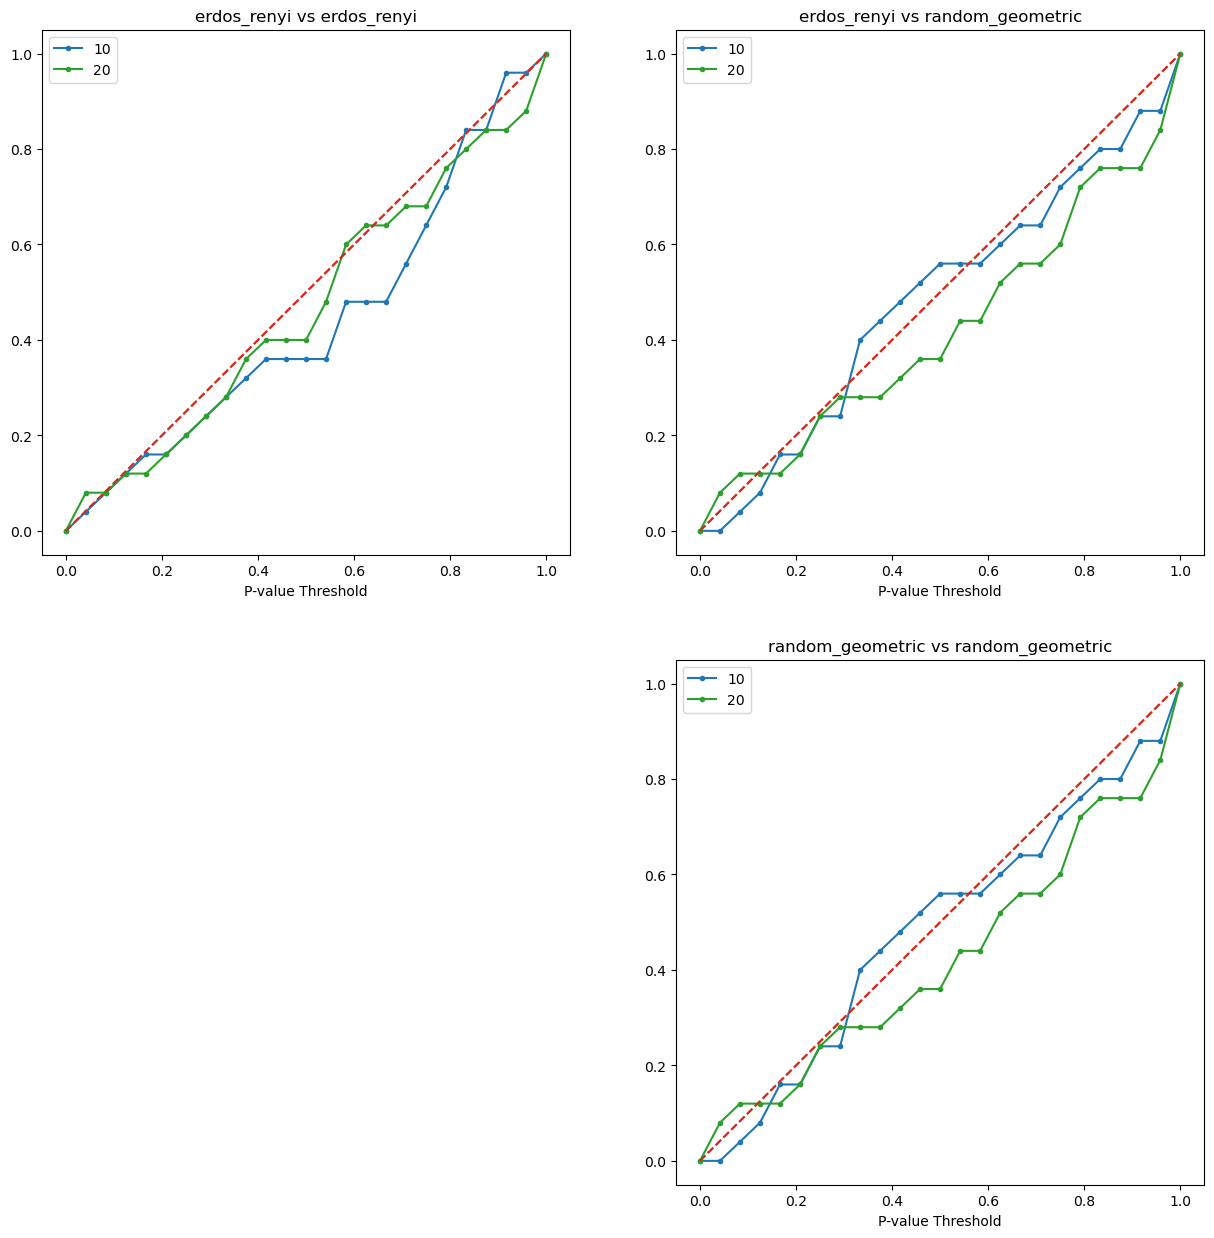

In [22]:
fig = plot_roc_curves(graph_types, n_graphs, eigen, params, n_simulations)
fig.savefig(os.path.join(output_path, 'result.png'))

## Debug

In [21]:
params

{'erdos_renyi': {'erdos_renyi': {10: [([0.4495427536225751,
      0.2801514659810761,
      0.6058147514707691,
      0.9232215466289632,
      0.5665600351040346,
      0.2109042331048924,
      0.8809314862700237,
      0.6200470651411832,
      0.72257267929471,
      0.35058085670616607],
     [0.48274518688278356,
      0.517169975459889,
      0.780623846336578,
      0.2966498127326461,
      0.6394602781780893,
      0.3745345367626177,
      0.4115342854168738,
      0.607813809168497,
      0.6673909334456302,
      0.5694277364059471]),
    ([0.2756034167531507,
      0.27687602884299173,
      0.5900143353580221,
      0.5463046818613069,
      0.07988180700699063,
      0.624440174330368,
      0.7596067088080528,
      0.2068930475620849,
      0.19611579400098617,
      0.3450447750835009],
     [0.6884506414823207,
      0.47561489645476773,
      0.335919532945548,
      0.31801092406833603,
      0.458387439324107,
      0.4256408886399479,
      0.5220477107220507,
 

In [17]:
params

{'erdos_renyi': {'erdos_renyi': {10: [([0.3491627558827864,
      0.3491627558827864,
      0.3491627558827864,
      0.3491627558827864,
      0.3491627558827864,
      0.3491627558827864,
      0.3491627558827864,
      0.3491627558827864,
      0.3491627558827864,
      0.3491627558827864],
     [0.33699699847371606,
      0.33699699847371606,
      0.33699699847371606,
      0.33699699847371606,
      0.33699699847371606,
      0.33699699847371606,
      0.33699699847371606,
      0.33699699847371606,
      0.33699699847371606,
      0.33699699847371606]),
    ([0.30205327119902686,
      0.30205327119902686,
      0.30205327119902686,
      0.30205327119902686,
      0.30205327119902686,
      0.30205327119902686,
      0.30205327119902686,
      0.30205327119902686,
      0.30205327119902686,
      0.30205327119902686],
     [0.5825035654819518,
      0.5825035654819518,
      0.5825035654819518,
      0.5825035654819518,
      0.5825035654819518,
      0.5825035654819518,
      